### PROBLEM 1: Recommender System using Collaborative Filtering

Implement a Movie Recommendation System and run it on the Movie Lens Dataset (Train vs Test). Mesure performance on test set using RMSE.

1. First you are required to compute first a user-user similarity based on ratings and movies in common.
2. Second, make rating predictions on the test set followoing the KNN idea: a prediction (user, movie) is the weighted average of other users' rating for the movie, weighted by user-similarity to the given user.

In [1]:
# Importing the required libraries

import math
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setting seed for reproducability

seed = 42
np.random.seed(seed)

#### Loading the Data

In [3]:
# DATA URLs

BASE_DIR = Path().cwd().parent
DATA_DIR = BASE_DIR / "data" / "ml-100k"

DATA_URL = DATA_DIR / "u.data"
DATA_URL

PosixPath('/home/kishoresampath/Documents/Northeastern Coursework/USML/Code_Files/Assignment_6/data/ml-100k/u.data')

In [4]:
# Loading the data

columns = ["user_id", "item_id", "rating", "timstamp"]

df = pd.read_csv(DATA_URL, delimiter="\t", header=None)
df.columns = columns

df.head()

,user_id,item_id,rating,timstamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


#### Exploratory Data Analysis

In [5]:
df.shape

(100000, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   100000 non-null  int64
 1   item_id   100000 non-null  int64
 2   rating    100000 non-null  int64
 3   timstamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [7]:
print("Checking for Null Values")

df.isnull().sum()

Checking for Null Values


user_id     0
item_id     0
rating      0
timstamp    0
dtype: int64

In [8]:
n_duplicates = df.duplicated().sum()
print(f"Number of duplicates = {n_duplicates}")

Number of duplicates = 0


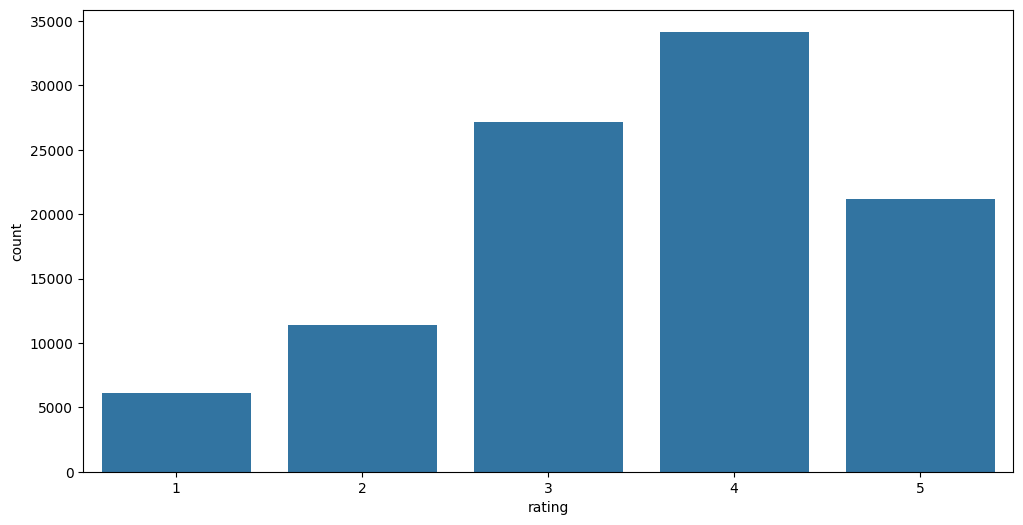

In [118]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="rating")
plt.show()

In [120]:
df["rating"].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

#### Data Preprocessing

In [9]:
n_users = df.user_id.nunique()
n_movies = df.item_id.nunique()

In [123]:
train_split = 0.8

n = df.shape[0]

train_test_split_idx = math.ceil(train_split * n)

train_df = df.iloc[:train_test_split_idx, :]
test_df = df.iloc[train_test_split_idx:, :]

In [124]:
train_df.shape

(80000, 4)

In [125]:
test_df.shape

(20000, 4)

#### Collaborative Filtering

In [13]:
user_items_utility_table = np.empty(shape=(n_users, n_movies))
user_items_utility_table[:] = np.nan

for _, r in tqdm(train_df.iterrows(), desc="Iterating over training data"):
    user_id = r["user_id"] - 1
    item_id = r["item_id"] - 1
    item_rating = r["rating"]

    user_items_utility_table[user_id, item_id] = item_rating

user_items_utility_table = pd.DataFrame(user_items_utility_table)
user_items_utility_table

Iterating over training data: 80000it [00:02, 28265.52it/s]


,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,5.0,3.0,NaN,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,2.0,NaN,NaN,NaN,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def calculate_user_stats(arr: np.array):
    non_nan_arr = arr[~np.isnan(arr)]
    
    sum = np.sum(non_nan_arr)
    n = non_nan_arr.shape[0]

    mean = sum / n
    sigma = np.sqrt((np.square(non_nan_arr).sum() / n) - np.square(mean))
    
    return mean, sigma

In [15]:
def normalize_items(arr: np.array, mean: float, std: float):
    normalized_user_items = (arr - mean) / std

    return normalized_user_items

In [16]:
user_user_similarity = np.zeros(shape=(n_users, n_users))

user_stats = np.empty(shape=(n_users, 2))

normalized_user_items_utility_table = np.copy(user_items_utility_table)

for i in range(n_users):
    user_items = user_items_utility_table.iloc[i, :].values
    
    user_mean, user_sigma = calculate_user_stats(user_items)
    user_stats[i, 0] = user_mean
    user_stats[i, 1] = user_sigma

    user_normalized_items = normalize_items(user_items, user_mean, user_sigma)
    normalized_user_items_utility_table[i, :] = user_normalized_items

In [17]:
normalized_user_items_utility_table

array([[ 1.12166775, -0.47798342,         nan, ...,         nan,
                nan,         nan],
       [ 0.32001773,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [56]:
for u in tqdm(range(n_users)):
    user_u_items = normalized_user_items_utility_table[u, :]
    user_u_rated_items = set(np.argwhere(~np.isnan(user_u_items)).squeeze())
    
    for v in range(n_users):
        user_v_items = normalized_user_items_utility_table[v, :]
        user_v_rated_items = set(np.argwhere(~np.isnan(user_v_items)).squeeze())

        common_items = list(user_u_rated_items.intersection(user_v_rated_items))
        n_common_items = len(common_items)

        if n_common_items > 0:
            user_uv_similarity = np.dot(user_u_items[common_items], user_v_items[common_items]) / n_common_items
        else:
            user_uv_similarity = 0
        
        user_user_similarity[u, v] = user_uv_similarity

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 943/943 [00:26<00:00, 35.48it/s]


In [57]:
user_user_similarity

array([[ 1.        ,  0.40836335,  0.16113311, ...,  0.20038042,
        -0.33890383,  0.1118678 ],
       [ 0.40836335,  1.        ,  0.18889757, ...,  0.56887347,
        -0.24424844,  0.41261968],
       [ 0.16113311,  0.18889757,  1.        , ...,  0.92269614,
         0.97063508,  0.39109314],
       ...,
       [ 0.20038042,  0.56887347,  0.92269614, ...,  1.        ,
        -0.26806023,  0.0529415 ],
       [-0.33890383, -0.24424844,  0.97063508, ..., -0.26806023,
         1.        , -0.24581726],
       [ 0.1118678 ,  0.41261968,  0.39109314, ...,  0.0529415 ,
        -0.24581726,  1.        ]])

In [121]:
test_df.head()

,user_id,item_id,rating,timstamp,predicted_rating
80000,863,1431,4,889289618,3.124765
80001,761,1287,1,876190072,1.544807
80002,863,322,1,889289327,2.538034
80003,828,694,2,891036717,3.349721
80004,889,523,4,880178078,4.052633


In [126]:
predictions = []

rmse = 0
cnt = 0

k = 300

mean_movie_rating = test_df["rating"].mean()

for _, r in tqdm(test_df.iterrows(), desc="Predicting"):
    user_u_id = r["user_id"]
    item_id = r["item_id"]

    users_similarities = user_user_similarity[user_u_id - 1, :]
    topk_users = np.argsort(users_similarities)[-k:]
    users_similarities = users_similarities[topk_users]
    
    other_users_movie_ratings = normalized_user_items_utility_table[topk_users, item_id - 1]

    non_nan_idx = ~np.isnan(other_users_movie_ratings)

    if non_nan_idx.sum() > 0:
        users_similarities = users_similarities[non_nan_idx]
        
        other_users_movie_ratings = other_users_movie_ratings[non_nan_idx]
    
        normalized_rating = np.dot(users_similarities, other_users_movie_ratings) / np.sum(users_similarities)
    
        user_mean, user_sigma = user_stats[user_u_id - 1]
        raw_rating = (normalized_rating * user_sigma) + user_mean

        predictions.append(raw_rating)
    
        rmse += np.square(r["rating"] - raw_rating)
    else:
        cnt += 1
        rmse += np.square(r["rating"] - mean_movie_rating)
        predictions.append(mean_movie_rating)

predictions = np.array(predictions)

rmse = np.sqrt(rmse / len(predictions))
print(f"RMSE: {rmse:.3f}")

print(cnt)

Predicting: 20000it [00:03, 5034.28it/s]

RMSE: 0.954
193


In [95]:
test_df.loc[:, "predicted_rating"] = predictions

/tmp/ipykernel_6071/4159144358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, "predicted_rating"] = predictions


In [96]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(
    test_df["rating"],
    test_df["predicted_rating"]
)

print(f"RMSE: {rmse:.3f}")

RMSE: 0.9544


In [129]:
predictions.max()

5.968357702524769

In [127]:
np.unique(np.round(predictions))

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.])

In [130]:
predictions = np.round(predictions)

predictions = np.where(predictions < 1, 1, predictions)

In [131]:
predictions = np.where(predictions > 5, 5, predictions)

In [132]:
np.unique(np.round(predictions))

array([1., 2., 3., 4., 5.])

In [133]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(
    test_df["rating"],
    predictions
)

print(f"RMSE: {rmse:.3f}")

RMSE: 0.998
